In [1]:
import numpy as np

def select_points_CEIL_simple(X, z, K, lambda_val):
    N, d = X.shape
    V_inv = np.eye(d)                     # initialize V^{-1}
    selected = []
    remaining = np.ones(N, dtype=bool)
    for _ in range(K):
        X_rem = X[remaining]
        # Score = z^T x + λ * (1 + x^T V^{-1} x)
        scores_query = X_rem.dot(z)
        B = X_rem.dot(V_inv)                              # = X_rem * V^{-1}
        xTvix = np.sum(B * X_rem, axis=1)                 # x^T V^{-1} x for each candidate
        scores = scores_query + lambda_val * (1.0 + xTvix)
        idx = np.argmax(scores)
        global_idx = np.nonzero(remaining)[0][idx]
        selected.append(global_idx)
        remaining[global_idx] = False
        # Update V^{-1} via Sherman-Morrison
        x_sel = X[global_idx]
        u = V_inv.dot(x_sel)
        V_inv -= np.outer(u, u) / (1.0 + x_sel.dot(u))
    return selected

def select_points_submod_no_log(X, z, K, lambda_val):
    N, d = X.shape
    V_inv = np.eye(d)
    selected = []
    remaining = np.ones(N, dtype=bool)
    for _ in range(K):
        X_rem = X[remaining]
        B = X_rem.dot(V_inv)
        xTvix = np.sum(B * X_rem, axis=1)
        p = B.dot(z)                                     # = z^T V^{-1} x for each
        # Score = (z^T V^{-1} x)^2 / (1 + x^T V^{-1} x) + λ * (1 + x^T V^{-1} x)
        scores = (p**2) / (1.0 + xTvix) + lambda_val * (1.0 + xTvix)
        idx = np.argmax(scores)
        global_idx = np.nonzero(remaining)[0][idx]
        selected.append(global_idx)
        remaining[global_idx] = False
        x_sel = X[global_idx]
        u = V_inv.dot(x_sel)
        V_inv -= np.outer(u, u) / (1.0 + x_sel.dot(u))
    return selected

def select_points_gaussian_ball(X, z, K, lambda_val):
    N, d = X.shape
    V_inv = np.eye(d)
    selected = []
    remaining = np.ones(N, dtype=bool)
    for _ in range(K):
        X_rem = X[remaining]
        B = X_rem.dot(V_inv)
        xTvix = np.sum(B * X_rem, axis=1)
        p = B.dot(z)
        # Norm term: x^T V^{-2} x = ||V^{-1} x||^2 
        norm2 = np.sum(B**2, axis=1)
        # Score = [(z^T V^{-1}x)^2 + λ * (x^T V^{-2}x)] / (1 + x^T V^{-1}x)
        scores = (p**2 + lambda_val * norm2) / (1.0 + xTvix)
        idx = np.argmax(scores)
        global_idx = np.nonzero(remaining)[0][idx]
        selected.append(global_idx)
        remaining[global_idx] = False
        x_sel = X[global_idx]
        u = V_inv.dot(x_sel)
        V_inv -= np.outer(u, u) / (1.0 + x_sel.dot(u))
    return selected

def select_points_query_bruteforce(X, z, K, lambda_val, sigma_rewrite=1.0, m_candidates=10):
    N, d = X.shape
    Z_candidates = np.random.normal(z, sigma_rewrite, size=(m_candidates, d))
    V_inv = np.eye(d)
    selected = []
    remaining = np.ones(N, dtype=bool)
    for _ in range(K):
        X_rem = X[remaining]
        B = X_rem.dot(V_inv)
        xTvix = np.sum(B * X_rem, axis=1)
        # Compute average Submodular score over m rewritten queries
        Dot = B.dot(Z_candidates.T)                        # shape (N_rem, m)
        avg_term = np.mean(Dot**2, axis=1) / (1.0 + xTvix)  # average of (z_i^T V^{-1}x)^2
        scores = avg_term 
        idx = np.argmax(scores)
        global_idx = np.nonzero(remaining)[0][idx]
        selected.append(global_idx)
        remaining[global_idx] = False
        x_sel = X[global_idx]
        u = V_inv.dot(x_sel)
        V_inv -= np.outer(u, u) / (1.0 + x_sel.dot(u))
    return selected

def select_points_query_mirror(X, z, K, lambda_val, sigma_rewrite=1.0, m_candidates=10, T=50, eta=0.5):
    N, d = X.shape
    Z_candidates = np.random.normal(z, sigma_rewrite, size=(m_candidates, d))
    alpha = np.ones(m_candidates) / m_candidates           # initial uniform weights
    S_final = []
    V_final_inv = None
    for t in range(T):
        # Greedy selection with current weights alpha on query samples
        V_inv = np.eye(d)
        remaining = np.ones(N, dtype=bool)
        S_current = []
        for _ in range(K):
            X_rem = X[remaining]
            B = X_rem.dot(V_inv)
            xTvix = np.sum(B * X_rem, axis=1)
            Dot = B.dot(Z_candidates.T)                    # (N_rem, m)
            weighted_term = (Dot**2).dot(alpha) / (1.0 + xTvix)
            scores = weighted_term 
            idx = np.argmax(scores)
            global_idx = np.nonzero(remaining)[0][idx]
            S_current.append(global_idx)
            remaining[global_idx] = False
            x_sel = X[global_idx]
            u = V_inv.dot(x_sel)
            V_inv -= np.outer(u, u) / (1.0 + x_sel.dot(u))
        # Update query weights via mirror ascent (exponentiated gradient)
        V_final_inv = V_inv
        S_final = S_current
        # Increase weights for queries with larger error (predictive variance)
        errs = np.array([z_i.dot(V_final_inv).dot(z_i) for z_i in Z_candidates])
        alpha *= np.exp(eta * errs)                        # 0.5 is step size
        alpha /= np.sum(alpha)                             # normalize
    return S_final

# Cell 1: Experimental Driver Code (Concise)

import numpy as np

def experiment(
    N,
    d,
    lambda_val,
    mean_train=0.0,
    var_train=1.0,
    mean_test=1.0,
    var_test=1.0,
    K=10,
    sigma_rewrite=1.0,
    m_candidates=10,
    repetitions_rewrite=50,
    M=400,
    eta = 0.5
):
    """
    Compares five selection methods on a single test point per run, repeated M times.
    For each run:
      1) Generate a random w_true in R^d.
      2) Generate X in R^{N x d} ~ Normal(mean_train, var_train).
         Generate y = X w_true + noise.
      3) Generate a test query z in R^d ~ Normal(mean_test, var_test).
         Compute y_true = z^T w_true.
      4) Use each method to pick K points from (X, y).
      5) Fit a small ridge regressor on those K points, predict z -> y_pred,
         accumulate squared error (y_pred - y_true)^2.
    Finally return an array of length 5 with average MSE across M runs, in order:
      [CEIL_no_log, Submod_no_log, GaussianBall, RewriteBrute, RewriteMirror]
    """
    mse_sum = np.zeros(5, dtype=float)
    for _ in range(M):
        w_true = np.random.randn(d)
        X = mean_train + np.sqrt(var_train) * np.random.randn(N, d)
        noise = 1 * np.random.randn(N)    # any scale
        y = X @ w_true + noise

        z = mean_test + np.sqrt(var_test) * np.random.randn(d)
        y_true = z @ w_true

        S1 = select_points_CEIL_simple(X, z, K, lambda_val)
        S2 = select_points_submod_no_log(X, z, K, lambda_val)
        S3 = select_points_gaussian_ball(X, z, K, lambda_val)
        S4 = select_points_query_bruteforce(X, z, K, lambda_val, sigma_rewrite, m_candidates)
        S5 = select_points_query_mirror(X, z, K, lambda_val, sigma_rewrite, m_candidates, T=repetitions_rewrite, eta = eta)

        for idx, subset in enumerate([S1, S2, S3, S4, S5]):
            X_sub = X[subset]
            y_sub = y[subset]
            d_ = X_sub.shape[1]
            A = X_sub.T @ X_sub + 0.02 * np.eye(d_)
            w_hat = np.linalg.solve(A, X_sub.T @ y_sub)
            y_pred = z @ w_hat
            mse_sum[idx] += (y_pred - y_true)**2

    return mse_sum / M

Varying N: 100%|██████████| 20/20 [1:11:07<00:00, 213.35s/it]


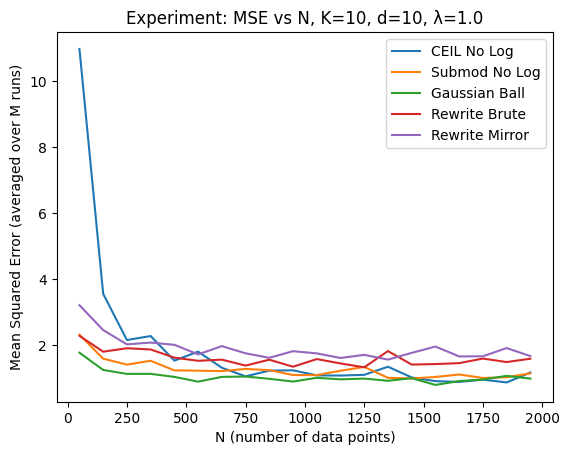

In [2]:
# Cell 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters for the experiment
K = 10
d = 10
lambda_val = 1.0
sigma = 5.0
sigma_rewrite = 1.0
m_candidates = 10
repetitions_rewrite = 50
M = 500   # number of runs for averaging

N_values = range(50, 2001, 100)

# Arrays for storing final MSEs for each method
mse_ceil_nolog = []
mse_submod_nolog = []
mse_gaussian_ball = []
mse_rewrites_brute = []
mse_rewrites_mirror = []

for N in tqdm(N_values, desc="Varying N"):
    # Each call returns an array of length=5 with MSE for the 5 methods
    #   [CEIL NoLog, Submod NoLog, GaussianBall, RewriteBrute, RewriteMirror]
    results = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

# Plotting (no error bars)
plt.figure()
plt.plot(N_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(N_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(N_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(N_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(N_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("N (number of data points)")
plt.ylabel("Mean Squared Error (averaged over M runs)")
plt.title(f"Experiment: MSE vs N, K={K}, d={d}, λ={lambda_val}")
plt.legend()
plt.show()


Varying λ: 100%|██████████| 20/20 [2:20:20<00:00, 421.01s/it]  


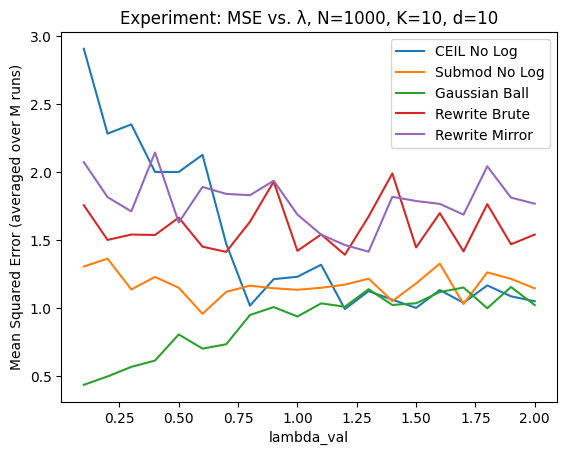

In [3]:
# Cell 3
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed experimental settings
N = 1000
K = 10
d = 10
sigma = 5.0
sigma_rewrite = 1.0
m_candidates = 10
repetitions_rewrite = 50
M = 500 

lambda_values = np.arange(0.1, 2.001, 0.1)

# Arrays for MSE
mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for lam in tqdm(lambda_values, desc="Varying λ"):
    results = experiment(
        N=N,
        d=d,
        lambda_val=lam,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

plt.figure()
plt.plot(lambda_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(lambda_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(lambda_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(lambda_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(lambda_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("lambda_val")
plt.ylabel("Mean Squared Error (averaged over M runs)")
plt.title(f"Experiment: MSE vs. λ, N={N}, K={K}, d={d}")
plt.legend()
plt.show()


Varying K:   0%|          | 0/10 [00:00<?, ?it/s]

Varying K: 100%|██████████| 10/10 [3:34:52<00:00, 1289.22s/it]


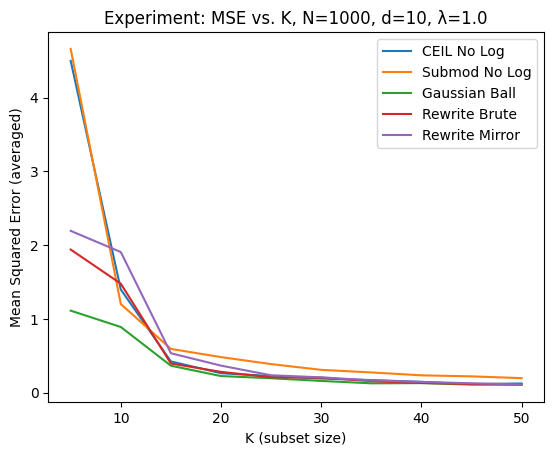

In [4]:
# Cell 5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed experimental settings
N = 1000
d = 10
lambda_val = 1.0
sigma = 5.0
sigma_rewrite = 1.0
m_candidates = 10
repetitions_rewrite = 50
M = 500 

K_values = range(5, 51, 5)

mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for K_val in tqdm(K_values, desc="Varying K"):
    results = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        K=K_val,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

plt.figure()
plt.plot(K_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(K_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(K_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(K_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(K_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("K (subset size)")
plt.ylabel("Mean Squared Error (averaged)")
plt.title(f"Experiment: MSE vs. K, N={N}, d={d}, λ={lambda_val}")
plt.legend()
plt.show()


Varying d:   0%|          | 0/7 [00:00<?, ?it/s]

Varying d: 100%|██████████| 7/7 [5:17:53<00:00, 2724.85s/it]  


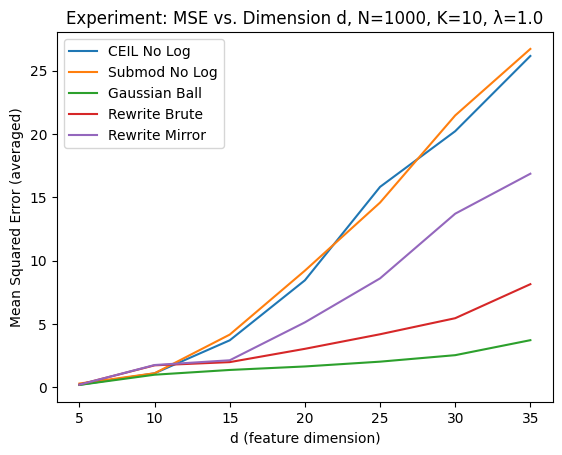

In [5]:
# Cell 6
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed experimental settings
N = 1000
K = 10
lambda_val = 1.0
sigma = 5.0
sigma_rewrite = 1.0
m_candidates = 10
repetitions_rewrite = 50
M = 500 

d_values = range(5, 36, 5)

mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for d_val in tqdm(d_values, desc="Varying d"):
    results = experiment(
        N=N,
        d=d_val,
        lambda_val=lambda_val,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

plt.figure()
plt.plot(d_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(d_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(d_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(d_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(d_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("d (feature dimension)")
plt.ylabel("Mean Squared Error (averaged)")
plt.title(f"Experiment: MSE vs. Dimension d, N={N}, K={K}, λ={lambda_val}")
plt.legend()
plt.show()


Varying T (mirror ascent steps): 100%|██████████| 11/11 [3:00:24<00:00, 984.06s/it] 


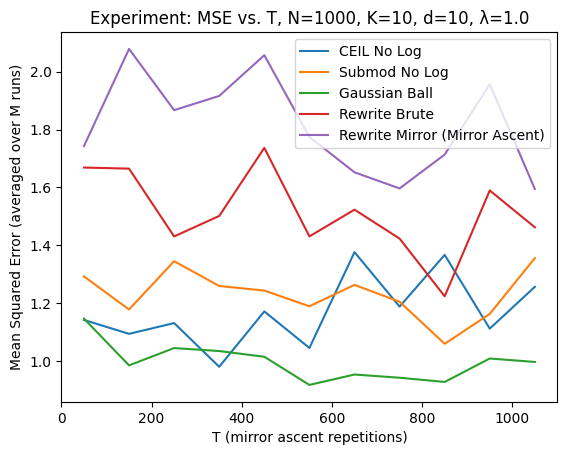

In [6]:
# Cell 7
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed experimental settings
N = 1000
K = 10
d = 10
lambda_val = 1.0
sigma = 5.0
sigma_rewrite = 1.0
m_candidates = 10
M = 500   # number of repeated runs per experiment

# We'll vary the 'repetitions_rewrite' parameter
T_values = range(50, 1051, 100)

# Arrays to store MSE results for each method
mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for T_val in tqdm(T_values, desc="Varying T (mirror ascent steps)"):
    results = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=T_val,
        M=M
    )
    # results is a length-5 array of MSEs for the 5 methods in order:
    # [CEIL_no_log, Submod_no_log, Gaussian_ball, Rewrite_brute, Rewrite_mirror]
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

# --- Plot results ---
plt.figure()

plt.plot(T_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(T_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(T_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(T_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(T_values, mse_rewrites_mirror, label="Rewrite Mirror (Mirror Ascent)")

plt.xlabel("T (mirror ascent repetitions)")
plt.ylabel("Mean Squared Error (averaged over M runs)")
plt.title(f"Experiment: MSE vs. T, N={N}, K={K}, d={d}, λ={lambda_val}")
plt.legend()
plt.show()


Varying mean_test: 100%|██████████| 11/11 [1:13:42<00:00, 402.07s/it]


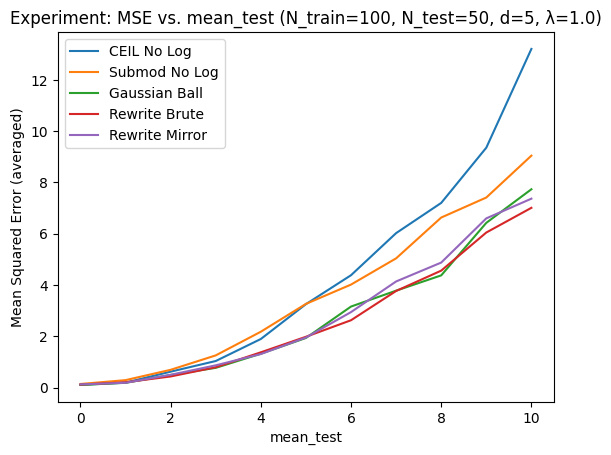

In [7]:
# Cell for mean_test sweep
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed experimental settings
N_train = 100
N_test  = 50
d = 5
lambda_val = 1.0
var_train = 1.0
mean_train = 0.0
var_test = 1.0
K = 10
sigma_rewrite = 1.0
m_candidates = 10
repetitions_rewrite = 50
M = 500 

mean_test_values = range(0, 11, 1)  # 0..10 in steps of 1

# Arrays to store final MSE for each method
mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for mt in tqdm(mean_test_values, desc="Varying mean_test"):
    # experiment(...) returns a length-5 array of final MSE for each method
    results = experiment(
        N = N,
        d            = d,
        lambda_val   = lambda_val,
        mean_train   = mean_train,
        var_train    = var_train,
        mean_test    = mt,
        var_test     = var_test,
        K            = K,
        sigma_rewrite= sigma_rewrite,
        m_candidates = m_candidates,
        repetitions_rewrite = repetitions_rewrite,
        M            = M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

# Plot result (no error bars)
plt.figure()
plt.plot(mean_test_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(mean_test_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(mean_test_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(mean_test_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(mean_test_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("mean_test")
plt.ylabel("Mean Squared Error (averaged)")
plt.title(f"Experiment: MSE vs. mean_test (N_train={N_train}, N_test={N_test}, d={d}, λ={lambda_val})")
plt.legend()
plt.show()


Varying var: 100%|██████████| 10/10 [12:11<00:00, 73.15s/it]


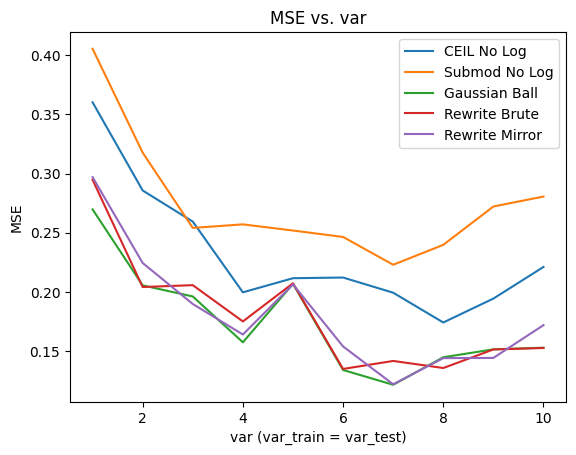

In [8]:
# Cell: Varying var (with var_train = var_test = var)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed parameters
N = 200
d = 5
lambda_val = 1.0
mean_train = 0.0
mean_test  = 1.0
K = 10
sigma_rewrite = 1.0
m_candidates  = 10
repetitions_rewrite = 50
M = 400

var_values = range(1, 11)  # 1..10

# Arrays to store final MSE
mse_ceil_nolog      = []
mse_submod_nolog    = []
mse_gaussian_ball   = []
mse_rewrites_brute  = []
mse_rewrites_mirror = []

for v in tqdm(var_values, desc="Varying var"):
    results = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        mean_train=mean_train,
        var_train=v,
        mean_test=mean_test,
        var_test=v,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M
    )
    mse_ceil_nolog.append(results[0])
    mse_submod_nolog.append(results[1])
    mse_gaussian_ball.append(results[2])
    mse_rewrites_brute.append(results[3])
    mse_rewrites_mirror.append(results[4])

plt.figure()
plt.plot(var_values, mse_ceil_nolog,      label="CEIL No Log")
plt.plot(var_values, mse_submod_nolog,    label="Submod No Log")
plt.plot(var_values, mse_gaussian_ball,   label="Gaussian Ball")
plt.plot(var_values, mse_rewrites_brute,  label="Rewrite Brute")
plt.plot(var_values, mse_rewrites_mirror, label="Rewrite Mirror")

plt.xlabel("var (var_train = var_test)")
plt.ylabel("MSE")
plt.title("MSE vs. var")
plt.legend()
plt.show()


Varying T: 100%|██████████| 11/11 [17:18:46<00:00, 5666.07s/it] 


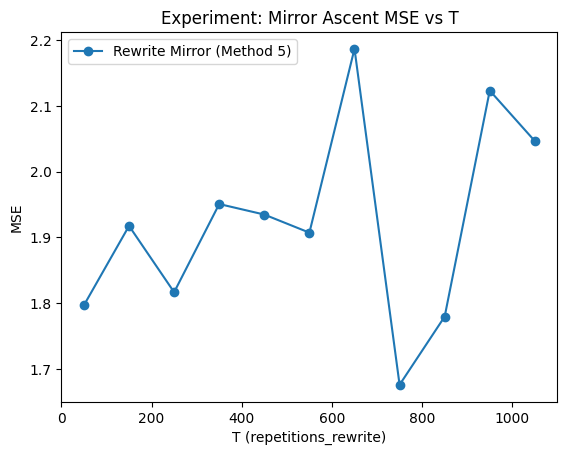

In [9]:
# Cell 1: Vary T from 50 to 1050 in steps of 100
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fixed hyperparameters for everything except T
N = 500
d = 10
lambda_val = 1.0
mean_train = 0.0
var_train  = 1.0
mean_test  = 1.0
var_test   = 1.0
K = 10
sigma_rewrite = 1.0
m_candidates = 10
M = 800
eta = 0.5  # default step size for mirror ascent

T_values = range(50, 1051, 100)
mse_mirror = []

for T_val in tqdm(T_values, desc="Varying T"):
    # experiment returns an array [CEIL, Submod, Gauss, RewriteBrute, RewriteMirror]
    res = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        mean_train=mean_train,
        var_train=var_train,
        mean_test=mean_test,
        var_test=var_test,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=T_val,
        M=M,
        eta=eta
    )
    # Mirror ascent method is index=4
    mse_mirror.append(res[4])

plt.figure()
plt.plot(T_values, mse_mirror, marker='o', label="Rewrite Mirror (Method 5)")
plt.xlabel("T (repetitions_rewrite)")
plt.ylabel("MSE")
plt.title("Experiment: Mirror Ascent MSE vs T")
plt.legend()
plt.show()


Varying sigma_rewrite:  68%|██████▊   | 13/19 [53:07<24:17, 242.99s/it] C:\Users\kapun\AppData\Local\Temp\ipykernel_3228\475125082.py:122: RuntimeWarning: overflow encountered in exp
  alpha *= np.exp(eta * errs)                        # 0.5 is step size
C:\Users\kapun\AppData\Local\Temp\ipykernel_3228\475125082.py:123: RuntimeWarning: invalid value encountered in divide
  alpha /= np.sum(alpha)                             # normalize
Varying sigma_rewrite: 100%|██████████| 19/19 [1:17:14<00:00, 243.93s/it]


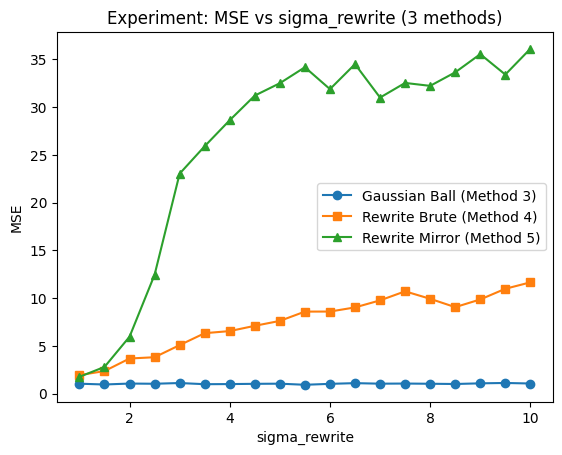

In [10]:
# Cell 2: Vary sigma_rewrite from 1 to 10 in steps of 0.5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 500
d = 10
lambda_val = 1.0
mean_train = 0.0
var_train  = 1.0
mean_test  = 1.0
var_test   = 1.0
K = 10
m_candidates = 10
repetitions_rewrite = 150
M = 800
eta = 0.5

# We only plot lines for Gaussian Ball (index=2),
# Rewrite Brute (index=3), Rewrite Mirror (index=4).
sigma_values = np.arange(1, 10.1, 0.5)

mse_gauss = []
mse_rewrite_brute = []
mse_rewrite_mirror = []

for s in tqdm(sigma_values, desc="Varying sigma_rewrite"):
    res = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        mean_train=mean_train,
        var_train=var_train,
        mean_test=mean_test,
        var_test=var_test,
        K=K,
        sigma_rewrite=s,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M,
        eta=eta
    )
    mse_gauss.append(res[2])
    mse_rewrite_brute.append(res[3])
    mse_rewrite_mirror.append(res[4])

plt.figure()
plt.plot(sigma_values, mse_gauss,           label="Gaussian Ball (Method 3)", marker='o')
plt.plot(sigma_values, mse_rewrite_brute,   label="Rewrite Brute (Method 4)", marker='s')
plt.plot(sigma_values, mse_rewrite_mirror,  label="Rewrite Mirror (Method 5)", marker='^')
plt.xlabel("sigma_rewrite")
plt.ylabel("MSE")
plt.title("Experiment: MSE vs sigma_rewrite (3 methods)")
plt.legend()
plt.show()


Varying eta: 100%|██████████| 14/14 [34:32<00:00, 148.03s/it]


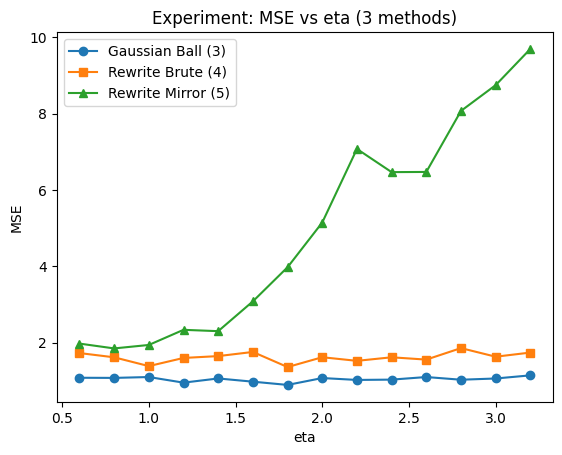

In [11]:
# Cell 3: Vary eta from 0.6 to 3.2 in steps of 0.2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 500
d = 10
lambda_val = 1.0
mean_train = 0.0
var_train  = 1.0
mean_test  = 1.0
var_test   = 1.0
K = 10
sigma_rewrite = 1.0
m_candidates  = 10
repetitions_rewrite = 150
M = 500

eta_values = np.arange(0.6, 3.21, 0.2)

mse_gauss = []
mse_rewrite_brute = []
mse_rewrite_mirror = []

for e in tqdm(eta_values, desc="Varying eta"):
    res = experiment(
        N=N,
        d=d,
        lambda_val=lambda_val,
        mean_train=mean_train,
        var_train=var_train,
        mean_test=mean_test,
        var_test=var_test,
        K=K,
        sigma_rewrite=sigma_rewrite,
        m_candidates=m_candidates,
        repetitions_rewrite=repetitions_rewrite,
        M=M,
        eta=e
    )
    # Indices: 2=GaussianBall, 3=RewriteBrute, 4=RewriteMirror
    mse_gauss.append(res[2])
    mse_rewrite_brute.append(res[3])
    mse_rewrite_mirror.append(res[4])

plt.figure()
plt.plot(eta_values, mse_gauss,           label="Gaussian Ball (3)", marker='o')
plt.plot(eta_values, mse_rewrite_brute,   label="Rewrite Brute (4)", marker='s')
plt.plot(eta_values, mse_rewrite_mirror,  label="Rewrite Mirror (5)", marker='^')
plt.xlabel("eta")
plt.ylabel("MSE")
plt.title("Experiment: MSE vs eta (3 methods)")
plt.legend()
plt.show()